In [367]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import remove_small_objects
import imageio

In [368]:
line_conf = np.load('line_detection/line_detec_confidence_map.npy')
morph_conf = np.load('morph_conf.npy')
nn_conf = np.load('yhat_21.npy')

In [369]:
def combine_confidence_maps(*maps):
    combined_map = np.mean(np.array(maps), axis=0)
    return combined_map


In [370]:
def apply_optic_disk_mask(combined_map, morphological_map, mask):
    return np.where(mask, morphological_map, combined_map)


In [371]:
def hybrid_vessel_segmentation(*maps, threshold = 80, apply_mask=False, morphological_map=None, mask=None):
    combined_map = combine_confidence_maps(*maps)
    if apply_mask and morphological_map is not None and mask is not None:
        combined_map = apply_optic_disk_mask(combined_map, morphological_map, mask)
    _, thresh_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    cleaned_image = remove_small_objects(thresh_img.astype(bool), min_size=100).astype(np.uint8) * 255
    return cleaned_image


In [372]:
line_conf = cv2.convertScaleAbs(line_conf, alpha=(255.0))
morph_conf = cv2.convertScaleAbs(morph_conf, alpha=(255.0))
nn_conf = cv2.convertScaleAbs(nn_conf, alpha=(255.0))

In [373]:
img = combine_confidence_maps(line_conf, morph_conf, nn_conf)

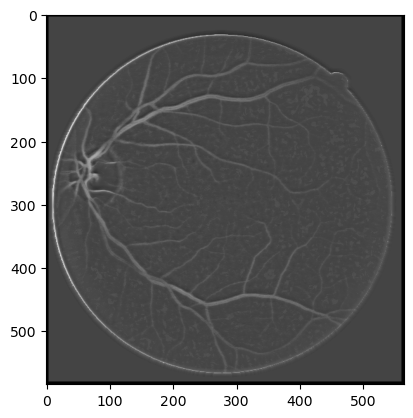

In [374]:
plt.imshow(img, cmap='gray')

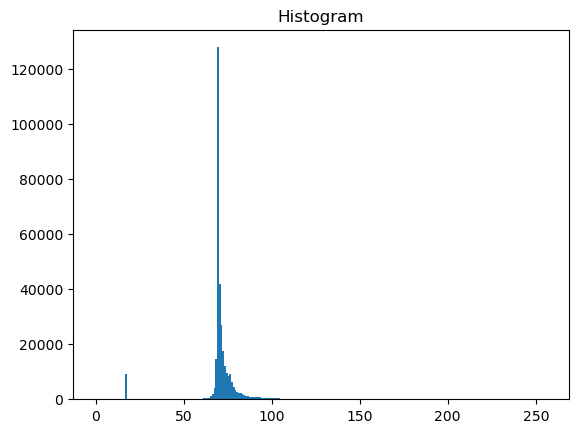

In [375]:
plt.hist(img.ravel(), bins=256, range=(0, 256))
plt.title('Histogram')
plt.show()

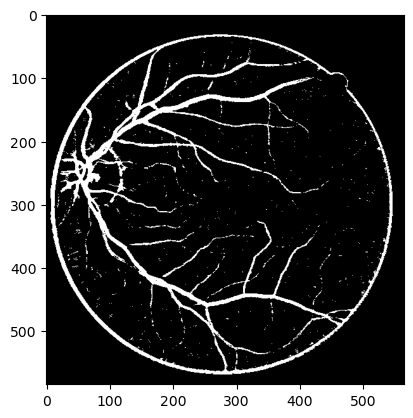

In [376]:
_, thresh_img = cv2.threshold(img, 80, 255, cv2.THRESH_BINARY)
plt.imshow(thresh_img, cmap='gray')

In [377]:
final_img = hybrid_vessel_segmentation(img, threshold=77)

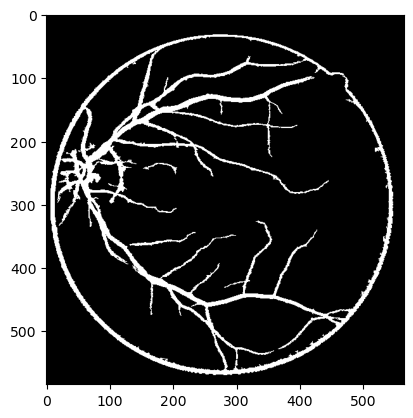

In [378]:
plt.imshow(final_img, cmap='gray')

In [379]:
def classify_pixels(hybrid_image, ground_truth):
    TP = np.logical_and(hybrid_image == 255, ground_truth == 255).astype(int) 
    FP = np.logical_and(hybrid_image == 255, ground_truth == 0).astype(int)
    FN = np.logical_and(hybrid_image == 0, ground_truth == 255).astype(int)
    TN = np.logical_and(hybrid_image == 0, ground_truth == 0).astype(int)
    
    comparison_image = np.zeros((*hybrid_image.shape, 3), dtype=np.uint8)
    comparison_image[TP == 1] = [0, 255, 0]
    comparison_image[FP == 1] = [255, 0, 0]
    comparison_image[FN == 1] = [0, 0, 255]
    
    eval_metrics = [TP, FP, FN, TN]
    
    return comparison_image, eval_metrics

(-0.5, 564.5, 583.5, -0.5)

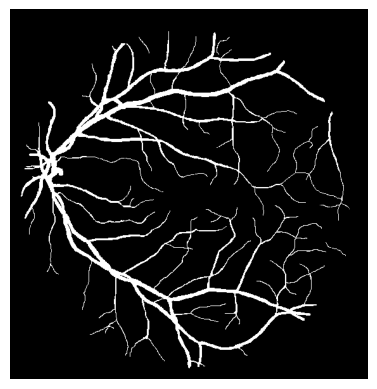

In [381]:
ground_truth_image = imageio.mimread('Drive/training/1st_manual/21_manual1.gif')[0]
plt.imshow(ground_truth_image, cmap='gray')
plt.axis('off')

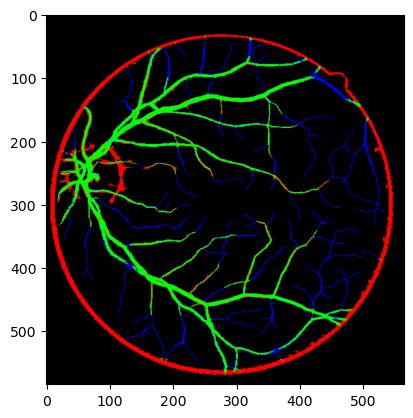

In [383]:
eval_metrics = []
classified_image, eval_metrics = classify_pixels(final_img, ground_truth_image)
plt.imshow(classified_image)